In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [9]:
# Load data from CSV file and perform data preprocessing
df = pd.read_csv('df_mostfre_stroke.csv')

In [10]:
X = df.loc[:, df.columns != 'MCQ160F']
y = df.MCQ160F

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [12]:
# Address class imbalance by oversampling training data using SMOTE
smote = SMOTE(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)
X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)


In [13]:
# Train XGBoost model using oversampled training data
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

C:\Users\Public\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[05:51:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot: >

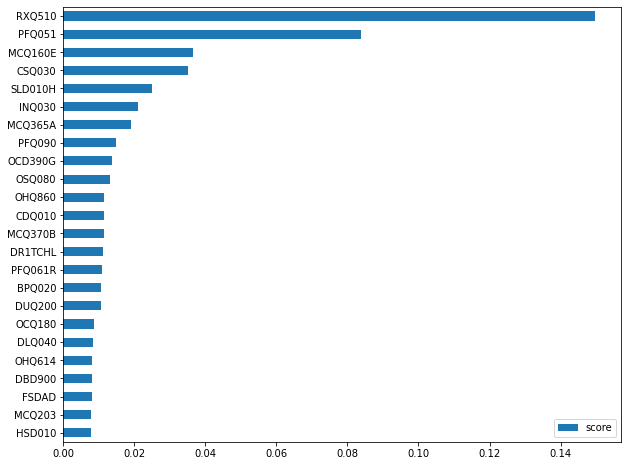

In [14]:
# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 24 features
xgbfs_ = data[:24]

# Plot feature score
xgbfs_.sort_values(by='score').plot(kind='barh', figsize=(10, 8))


In [7]:
# final variables
var_list = [ 'PFQ051', 'MCQ160E', 'CSQ030', 'SLD010H', 'INQ030', 'MCQ365A', 'PFQ090', 'OHQ860', 'CDQ010', 'MCQ370B', 'PFQ061R', 'BPQ020', 'DUQ200', 'OCQ180', 'DLQ040', 'OHQ614', 'DBD900', 'FSDAD', 'MCQ203', 'HSD010', 'MCQ160F']
df_final = df.filter(var_list)

In [20]:
df_final.to_csv(r'final_testset1_stroke.csv', index=False)

In [8]:
X_ = df_final.loc[:, df_final.columns != 'MCQ160F']
y = df_final.MCQ160F

# Data transformation by MinMax Scaler
minmax=MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_), columns=X_.columns)

In [9]:
# Split final data into training, validation, and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [10]:
#Should not resample test set and val set
smote = SMOTE(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)


In [11]:
mscore=[]

In [12]:
# Define function to print confusion matrix
def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

# logistic regression without parameter tuning

In [13]:
# Train Logistic regression model with default parameters and print evaluation metrics
lr_clf = LogisticRegression(random_state=11).fit(X_train_sm, y_train_sm)
y_pred_lr1 = lr_clf.predict(X_test)
accuracy = lr_clf.score(X_test, y_test)

print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_lr1)

print(classification_report(y_test, y_pred_lr1))
confusion(y_test, y_pred_lr1)

Accuracy Score: 0.7742805755395683
Prediction: [0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      1076
           1       0.09      0.69      0.17        36

    accuracy                           0.77      1112
   macro avg       0.54      0.74      0.52      1112
weighted avg       0.96      0.77      0.85      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         836         240
True[1]          11          25


,Predict[0],Predict[1]
True[0],836,240
True[1],11,25


roc_auc_score for Logistic Regression:  0.8107187112763321


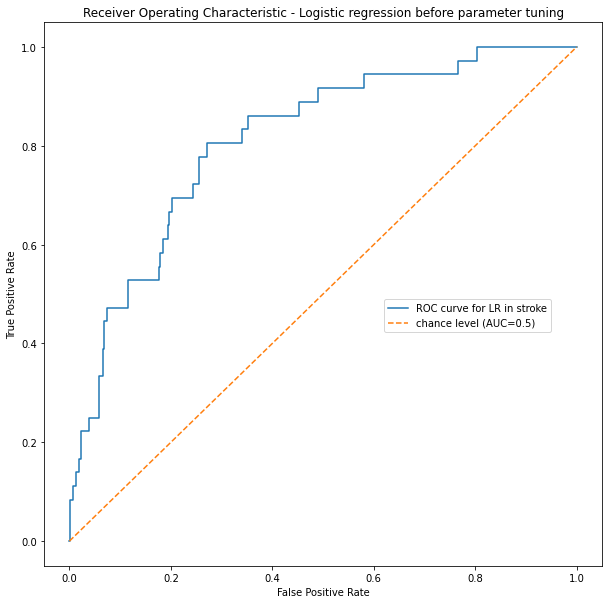

In [14]:
# Plot ROC curve for logistic regression model
y_score_lr = lr_clf.predict_proba(X_test)[:,1]
false_positive_rate_lr, true_positive_rate_lr, threshold_lr = roc_curve(y_test, y_score_lr)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score_lr))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression before parameter tuning')
plt.plot(false_positive_rate_lr, true_positive_rate_lr, label = "ROC curve for LR in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

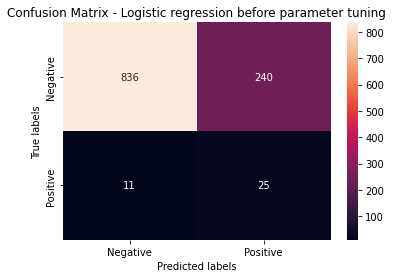

In [15]:
# Print confusion matrix for logistic regression model
cm = confusion_matrix(y_test, y_pred_lr1)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Logistic regression before parameter tuning')
ax.xaxis.set_ticklabels(["Negative", "Positive"])
ax.yaxis.set_ticklabels(["Negative", "Positive"])


# logistic regression with parameter tuning

In [16]:
# Define parameter distributions for random search on LR
c = stats.uniform(0, 10)
max_iter = [100, 200, 500]
solver = ['lbfgs','liblinear', 'newton-cholesky']
random_grid_lr = {'max_iter': max_iter, 'solver': solver, 'C': c}

In [34]:
# Train logistic regression model with random search and print evaluation metrics
lr = LogisticRegression()
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid_lr, n_iter = 100, cv = 5, scoring='recall', random_state=11, n_jobs = -1)
lr_random.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000193BB830D90>,
                                        'max_iter': [100, 200, 500],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cholesky']},
                   random_state=11, scoring='recall')

In [35]:
lr_random.best_params_

{'C': 7.853887219515014, 'max_iter': 100, 'solver': 'liblinear'}

In [36]:
best_random = lr_random.best_estimator_
best_random.fit(X_train_sm, y_train_sm)
y_pred_lr2 = best_random.predict(X_test)
accuracy = best_random.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_lr2)
print(classification_report(y_test, y_pred_lr2))
confusion(y_test, y_pred_lr2)

Accuracy Score: 0.7760791366906474
Prediction: [0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      1076
           1       0.10      0.69      0.17        36

    accuracy                           0.78      1112
   macro avg       0.54      0.74      0.52      1112
weighted avg       0.96      0.78      0.85      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         838         238
True[1]          11          25


,Predict[0],Predict[1]
True[0],838,238
True[1],11,25


roc_auc_score for Logistic Regression:  0.8164498141263941


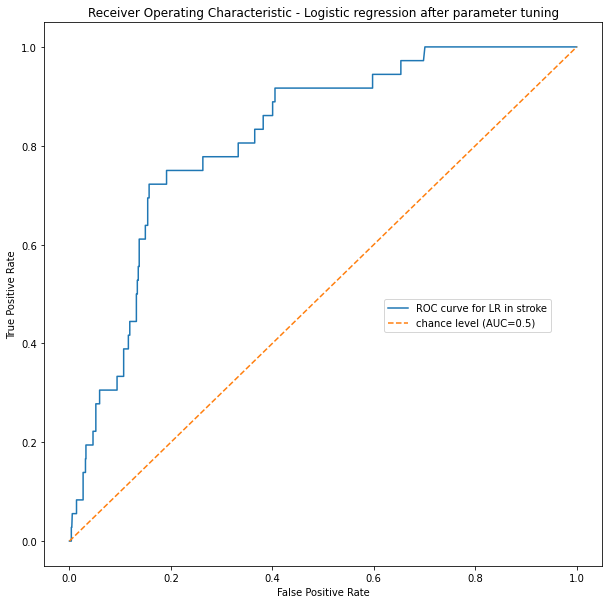

In [65]:
y_score_lr2 = best_random.predict_proba(X_test)[:,1]
false_positive_rate_lr2, true_positive_rate_lr2, threshold_lr2 = roc_curve(y_test, y_score_lr2)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score_lr2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression after parameter tuning')
plt.plot(false_positive_rate_lr2, true_positive_rate_lr2, label = "ROC curve for LR in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

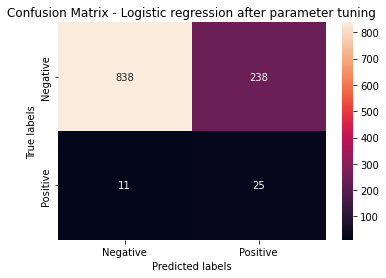

In [53]:
# Print confusion matrix for logistic regression model
cm = confusion_matrix(y_test, y_pred_lr2)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Logistic regression after parameter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


# Random Forest without parameter tuning

In [38]:
# Train random forest model with default parameters and print evaluation metrics
rnd_clf = RandomForestClassifier(random_state=11)
rnd_clf.fit(X_train_sm, y_train_sm)
y_pred_rnd1 = rnd_clf.predict(X_test)
accuracy = rnd_clf.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_rnd1)
print(classification_report(y_test, y_pred_rnd1))
confusion(y_test, y_pred_rnd1)

Accuracy Score: 0.9550359712230215
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1076
           1       0.15      0.08      0.11        36

    accuracy                           0.96      1112
   macro avg       0.56      0.53      0.54      1112
weighted avg       0.94      0.96      0.95      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        1059          17
True[1]          33           3


,Predict[0],Predict[1]
True[0],1059,17
True[1],33,3


roc_auc_score for Random Forest:  0.7854450640231307


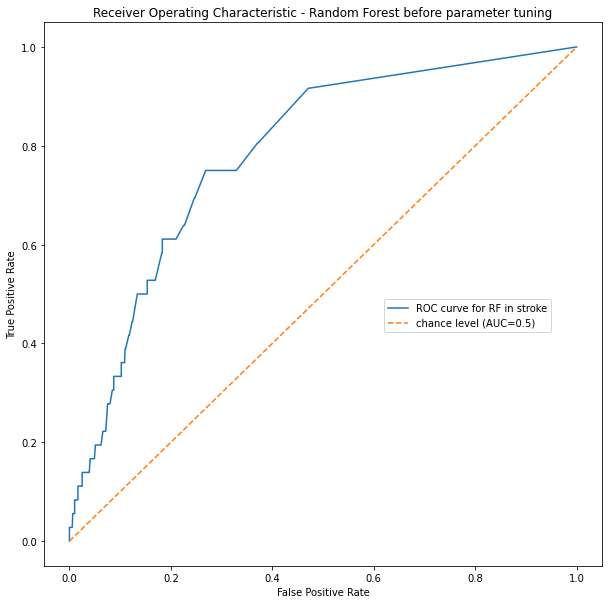

In [39]:
y_score_rnd1 = rnd_clf.predict_proba(X_test)[:,1]
false_positive_rate_rnd1, true_positive_rate_rnd1, threshold_rnd1 = roc_curve(y_test, y_score_rnd1)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score_rnd1))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest before parameter tuning')
plt.plot(false_positive_rate_rnd1, true_positive_rate_rnd1, label = "ROC curve for RF in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

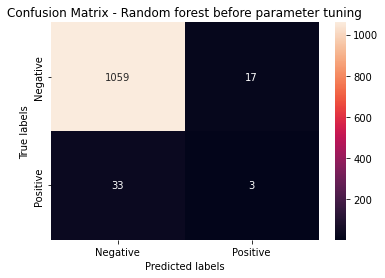

In [40]:
# Print confusion matrix for Random Forest model
cm = metrics.confusion_matrix(y_test, y_pred_rnd1)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Random forest before parameter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


# Random Forest with parameter tuning

In [47]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [5, 10, 20, None]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap
        }

In [51]:
# Train Random Forest model with random search and print evaluation metrics
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, scoring='accuracy', random_state=42, n_jobs = -1)
rf_random.fit(X_val, y_val)

C:\Users\Liu Sze Yi\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, None],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=11, scoring='accuracy')

In [52]:
rf_random.best_params_

{'n_estimators': 100, 'max_depth': 5, 'bootstrap': True}

In [60]:
best_random = RandomForestClassifier(n_estimators =100,max_depth=5,bootstrap=True, random_state=42)
best_random.fit(X_train_sm, y_train_sm)
y_pred_rnd2 = best_random.predict(X_test)
accuracy = best_random.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_rnd2)
print(classification_report(y_test, y_pred_rnd2))
confusion(y_test, y_pred_rnd2)


Accuracy Score: 0.8516187050359713
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1076
           1       0.13      0.61      0.21        36

    accuracy                           0.85      1112
   macro avg       0.56      0.74      0.56      1112
weighted avg       0.96      0.85      0.90      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         925         151
True[1]          14          22


,Predict[0],Predict[1]
True[0],925,151
True[1],14,22


roc_auc_score for Random Forest:  0.8164498141263941


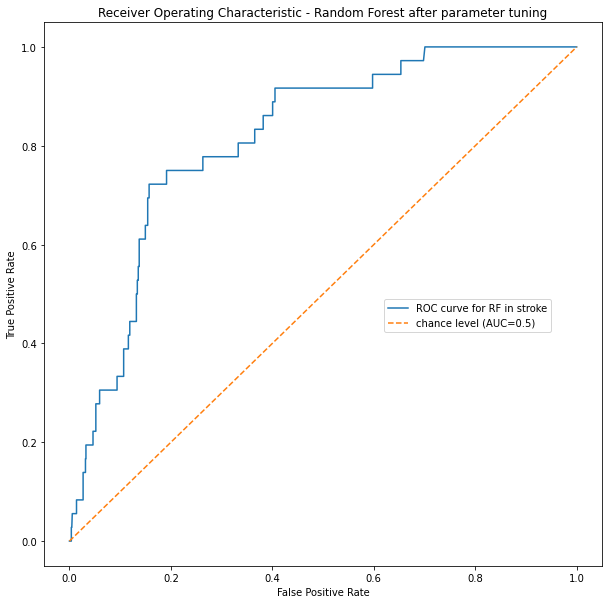

In [63]:
y_score_rnd2 = best_random.predict_proba(X_test)[:,1]
false_positive_rate_rnd2, true_positive_rate_rnd2, threshold_rnd2 = roc_curve(y_test, y_score_rnd2)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score_rnd2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest after parameter tuning')
plt.plot(false_positive_rate_rnd2, true_positive_rate_rnd2, label = "ROC curve for RF in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

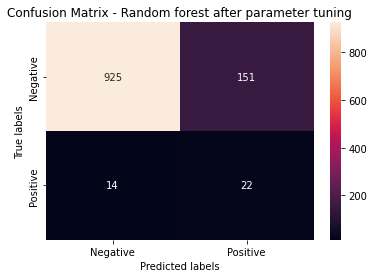

In [64]:
# Print confusion matrix for Random Forest model
cm = confusion_matrix(y_test, y_pred_rnd2)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Random forest after parameter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


# SVM without parameter tuning

In [71]:
# Train random forest model with default parameters and print evaluation metrics
svm_clf = SVC(random_state=1, probability=True)
svm_clf.fit(X_train_sm, y_train_sm)
y_pred_svm1 = svm_clf.predict(X_test)
accuracy = svm_clf.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_svm1)

print(classification_report(y_test, y_pred_svm1))
confusion(y_test, y_pred_svm1)

Accuracy Score: 0.8884892086330936
Prediction: [0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1076
           1       0.11      0.33      0.16        36

    accuracy                           0.89      1112
   macro avg       0.54      0.62      0.55      1112
weighted avg       0.95      0.89      0.92      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         976         100
True[1]          24          12


,Predict[0],Predict[1]
True[0],976,100
True[1],24,12


roc_auc_score for SVM:  0.643045229244114


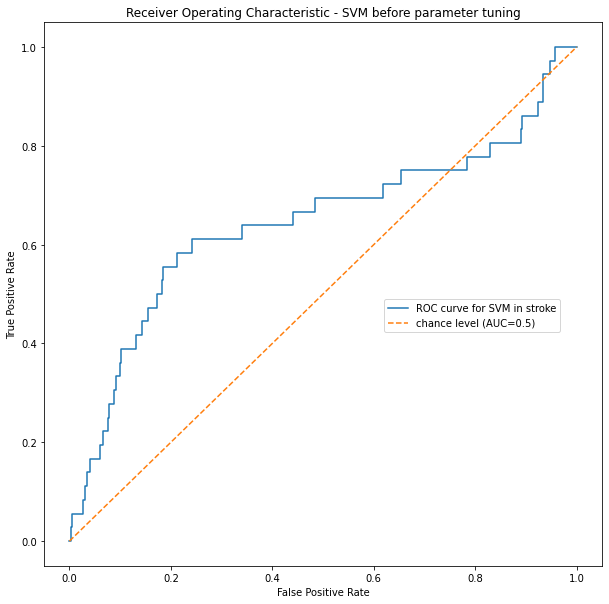

In [72]:
y_score_svm1 = svm_clf.predict_proba(X_test)[:,1]
false_positive_rate_svm1, true_positive_rate_svm1, threshold_svm1 = roc_curve(y_test, y_score_svm1)
print('roc_auc_score for SVM: ', roc_auc_score(y_test, y_score_svm1))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM before parameter tuning')
plt.plot(false_positive_rate_svm1, true_positive_rate_svm1, label = "ROC curve for SVM in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

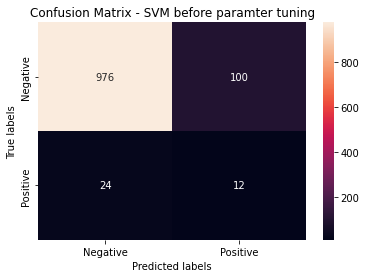

In [73]:
# Print confusion matrix for SVM model
cm = metrics.confusion_matrix(y_test, y_pred_svm1)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM before paramter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);


In [102]:
c = stats.uniform(2, 10)
gamma = stats.uniform(0.1, 1)
kernel = ['rbf', 'poly', 'sigmoid']
probability=[True, False]

random_grid = {'C': c,
               'gamma': gamma,
               'kernel': kernel,
               'probability': probability
        }
pprint(random_grid)


{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000193B98B4040>,
 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000193B91D7040>,
 'kernel': ['rbf', 'poly', 'sigmoid'],
 'probability': [True, False]}


In [103]:
svm = SVC()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, n_iter = 100, cv = 5, scoring='f1_micro', random_state=11, n_jobs = -1)
svm_random.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000193B98B4040>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000193B91D7040>,
                                        'kernel': ['rbf', 'poly', 'sigmoid'],
                                        'probability': [True, False]},
                   random_state=11, scoring='f1_micro')

In [104]:
svm_random.best_params_

{'C': 4.469981527203757,
 'gamma': 0.15295186810844733,
 'kernel': 'poly',
 'probability': True}

In [107]:
best_random = svm_random.best_estimator_
best_random.fit(X_train_sm, y_train_sm)
y_pred_svm2 = best_random.predict(X_test)
accuracy = best_random.score(X_test, y_test)
print('Accuracy Score:', accuracy)
print('Prediction:', y_pred_svm2)
print(classification_report(y_test, y_pred_svm2))
confusion(y_test, y_pred_svm2)


Accuracy Score: 0.8732014388489209
Prediction: [0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1076
           1       0.09      0.31      0.13        36

    accuracy                           0.87      1112
   macro avg       0.53      0.60      0.53      1112
weighted avg       0.95      0.87      0.91      1112

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         960         116
True[1]          25          11


,Predict[0],Predict[1]
True[0],960,116
True[1],25,11


roc_auc_score for SVM:  0.5755111524163569


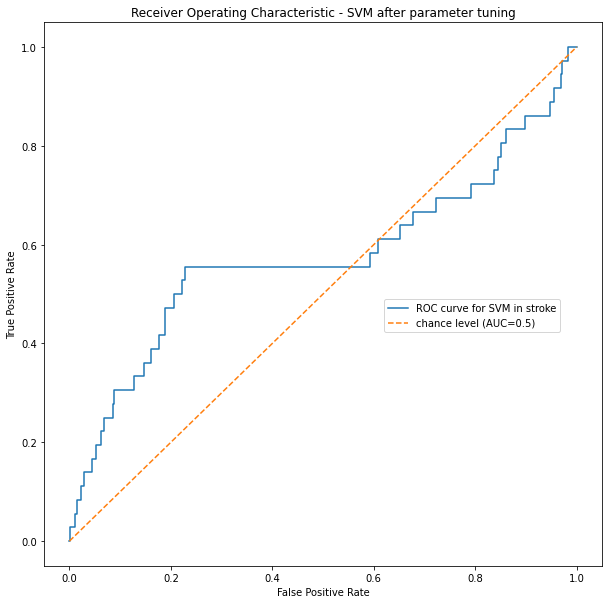

In [108]:
y_score_svm2 = best_random.predict_proba(X_test)[:,1]
false_positive_rate_svm2, true_positive_rate_svm2, threshold_svm2 = roc_curve(y_test, y_score_svm2)
print('roc_auc_score for SVM: ', roc_auc_score(y_test, y_score_svm2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM after parameter tuning')
plt.plot(false_positive_rate_svm2, true_positive_rate_svm2, label = "ROC curve for SVM in stroke")
plt.plot([0, 1], ls="--", label="chance level (AUC=0.5)")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend( bbox_to_anchor=(0.6,0.5))
plt.show()

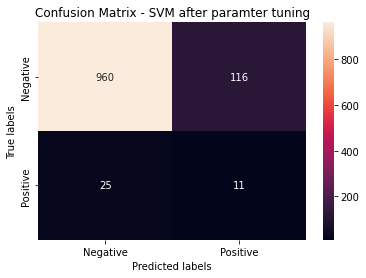

In [110]:
# Print confusion matrix for SVM model
cm = metrics.confusion_matrix(y_test, y_pred_svm2)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM after paramter tuning'); 
ax.xaxis.set_ticklabels(["Negative", "Positive"]); ax.yaxis.set_ticklabels(["Negative", "Positive"]);
